In [1]:
import hypothesis as h
import numpy as np
import glob
import torch
import os
import matplotlib.pyplot as plt
from scipy.stats import kstest, uniform

from matplotlib import cm
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1 import Divider
from mpl_toolkits.axes_grid1.axes_size import Fixed, Scaled
from hypothesis.plot import make_square

In [2]:
h.plot.activate()

In [3]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

## Setup

In [4]:
simulation_budgets = [2 ** x for x in range(10, 18)]
problems = ['slcp', 'mg1', 'weinberg', 'lotka_volterra', 'spatialsir', 'gw']
problem_titles = {
    problems[0]: 'SLCP',
    problems[1]: 'M/G/1',
    problems[2]: 'Weinberg',
    problems[3]: 'Lotka Volterra',
    problems[4]: 'Spatial SIR',
    problems[5]: 'Gravitational Waves'
}
problem_lrs = {
    problems[0]: '0.001',
    problems[1]: '0.001',
    problems[2]: '0.001',
    problems[3]: '0.001',
    problems[4]: '0.001',
    problems[5]: '0.001'
}
problem_nb_params = {
    problems[0]: 2,
    problems[1]: 3,
    problems[2]: 1,
    problems[3]: 2,
    problems[4]: 2,
    problems[5]: 2
}

levels = np.linspace(0.05, 0.95, 19)
colors = cm.get_cmap('viridis', len(simulation_budgets)).colors
colors_levels = cm.get_cmap('viridis', len(levels)).colors
batch_size = '128'

## Utilities

In [5]:
def area_under_expected_coverage(method, problem, simulations, gamma=None, schedule=False):
    method_name = method.split(' ')[0]
    if method_name == 'npe':
        query = '/scratch/projects/casbi/workflows/coverage_simulations_and_bias_reduction/' + problem + '/output/' + str(simulations) + '/without-regularization/'
        if 'ensemble' not in method:
            query += '/flow-sbi-0*/coverage.npy'
        else:
            query += '/coverage-flow-sbi.npy'
    else:
        query = '../' + method_name + '/' + problem + '/output/estimator/' + str(simulations) + '/' + batch_size + '/' + problem_lrs[problem]
        if gamma is not None:
            query += '/' + str(gamma)
        if schedule:
            query += '/schedule'
        
        if 'ensemble' not in method:
            query += '/*/coverage.npy'
        else:
            query += '/coverage.npy'
    files = glob.glob(query)
    if len(files) == 0:
        return None, None
    
    differences = []
    for f in files:
        difference = np.load(f) - levels
        differences.append(difference)
    

    summed = np.mean(differences, axis=1)

    return np.mean(summed), np.std(summed)

In [6]:
def plot_problem(axes, problem):
    # Plot NPE
    plot_npe(problem, axes[0])
    # Plot NPE ensemble
    plot_npe_ensemble(problem, axes[1])
    # Plot NRE
    plot_nre(problem, axes[2])
    # Plot NRE ensemble
    plot_nre_ensemble(problem, axes[3])
    # Plot CNRE
    plot_cnre(problem, axes[4])
    # Plot CNRE ensemble
    plot_cnre_ensemble(problem, axes[5])

In [7]:
def plot_npe(problem, ax):
    for index, simulation_budget in enumerate(simulation_budgets):
        coverages = []
        paths = glob.glob('../old/' + problem + '/output/' + str(simulation_budget) + '/without-regularization/flow-sbi-0*/coverage.npy')
        coverages = [np.flip(np.load(path)).reshape(1, -1) for path in paths]
        if len(coverages) <= 1:
            continue
        coverages = np.vstack(coverages)
        m_coverages = np.flip(np.mean(coverages, axis=0))  # Average of coverages
        s_coverages = np.flip(np.std(coverages, axis=1))  # STD of coverages
        ax.plot(levels, m_coverages, c=colors[index], label=simulation_budget)

In [8]:
def plot_npe_ensemble(problem, ax):
    learning_rate = problem_lrs[problem]
    for index, simulation_budget in enumerate(simulation_budgets):
        coverages = []
        path = '../old/' + problem + '/output/' + str(simulation_budget) + '/without-regularization/coverage-flow-sbi.npy'
        if os.path.exists(path):
            coverage = np.load(path)
            ax.plot(levels, coverage, c=colors[index], label=simulation_budget)

In [9]:
def plot_nre(problem, ax):
    learning_rate = problem_lrs[problem]
    for index, simulation_budget in enumerate(simulation_budgets):
        coverages = []
        paths = glob.glob('../nre/' + problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/*/coverage.npy')
        coverages = [np.load(path).reshape(1, -1) for path in paths]
        if len(coverages) <= 1:
            continue
        coverages = np.vstack(coverages)
        m_coverages = np.flip(np.mean(coverages, axis=0))  # Average of coverages
        s_coverages = np.flip(np.std(coverages, axis=1))  # STD of coverages
        ax.plot(levels, m_coverages, c=colors[index], label=simulation_budget)

In [10]:
def plot_nre_ensemble(problem, ax):
    learning_rate = problem_lrs[problem]
    for index, simulation_budget in enumerate(simulation_budgets):
        coverages = []
        path = '../nre/' + problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/coverage.npy'
        if os.path.exists(path):
            coverage = np.flip(np.load(path))
            ax.plot(levels, coverage, c=colors[index], label=simulation_budget)

In [11]:
def plot_cnre(problem, ax):
    if problem == "spatialsir/output_old":
        learning_rate = problem_lrs["spatialsir"]
    else:
        learning_rate = problem_lrs[problem]
    for index, simulation_budget in enumerate(simulation_budgets):
        coverages = []
        query = problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/*/coverage.npy'
        paths = glob.glob(query)
        coverages = [np.load(path).reshape(1, -1) for path in paths]
        if len(coverages) == 0:
            continue
        elif len(coverages) == 1:
            c = np.flip(coverages[0].reshape(-1))
        else:
            coverages = np.vstack(coverages)
            c = np.flip(np.mean(coverages, axis=0))  # Average of coverages
            s_coverages = np.flip(np.std(coverages, axis=1))  # STD of coverages
        ax.plot(levels, c, c=colors[index], label=simulation_budget)

In [12]:
def plot_cnre_ensemble(problem, ax):
    learning_rate = problem_lrs[problem]
    for index, simulation_budget in enumerate(simulation_budgets):
        coverages = []
        path = problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/coverage.npy'
        if os.path.exists(path):
            coverage = np.flip(np.load(path))
            ax.plot(levels, coverage, c=colors[index], label=simulation_budget)

In [13]:
def plot_ratio_npe(problem, ax):
    learning_rate = problem_lrs[problem]
    for index, simulation_budget in enumerate(simulation_budgets):
        coverages = []
        paths = glob.glob('../ratio_npe/' + problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/*/coverage.npy')
        coverages = [np.load(path).reshape(1, -1) for path in paths]
        if len(coverages) <= 1:
            continue
        coverages = np.vstack(coverages)
        m_coverages = np.flip(np.mean(coverages, axis=0))  # Average of coverages
        s_coverages = np.flip(np.std(coverages, axis=1))  # STD of coverages
        ax.plot(levels, m_coverages, c=colors[index], label=simulation_budget)

In [14]:
def plot_ratio_npe_ensemble(problem, ax):
    learning_rate = problem_lrs[problem]
    for index, simulation_budget in enumerate(simulation_budgets):
        coverages = []
        path = '../ratio_npe/' + problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/coverage.npy'
        if os.path.exists(path):
            coverage = np.flip(np.load(path))
            ax.plot(levels, coverage, c=colors[index], label=simulation_budget)

In [15]:
def plot_ratio_cnpe(problem, ax):
    learning_rate = problem_lrs[problem]
    for index, simulation_budget in enumerate(simulation_budgets):
        coverages = []
        paths = glob.glob('../ratio_cnpe/' + problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/*/coverage.npy')
        coverages = [np.load(path).reshape(1, -1) for path in paths]
        if len(coverages) <= 1:
            continue
        coverages = np.vstack(coverages)
        m_coverages = np.flip(np.mean(coverages, axis=0))  # Average of coverages
        s_coverages = np.flip(np.std(coverages, axis=1))  # STD of coverages
        ax.plot(levels, m_coverages, c=colors[index], label=simulation_budget)

In [16]:
def plot_ratio_cnpe_ensemble(problem, ax):
    learning_rate = problem_lrs[problem]
    for index, simulation_budget in enumerate(simulation_budgets):
        coverages = []
        path = '../ratio_cnpe/' + problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/coverage.npy'
        if os.path.exists(path):
            coverage = np.flip(np.load(path))
            ax.plot(levels, coverage, c=colors[index], label=simulation_budget)

In [17]:
def plot_mi_problem(axes, problem):
    plot_mi_nre(problem, axes[0])
    plot_mi_nre_ensemble(problem, axes[1])
    plot_mi_cnre(problem, axes[2])
    plot_mi_cnre_ensemble(problem, axes[3])

In [18]:
def plot_mi_nre(problem, ax):
    ax.set_xscale('log')
    
    # Mutual information type 1
    budgets = []
    mis = []
    learning_rate = problem_lrs[problem]
    for simulation_budget in simulation_budgets:
        # Load type 1
        query = '../nre/' + problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/*/mi-1.npy'
        paths = glob.glob(query)
        if len(paths) == 0:
            continue
        budgets.append(simulation_budget)
        mis.append(np.mean([np.load(path).reshape(1, -1) for path in paths]))
    if len(budgets) > 0:
        ax.plot(budgets, mis, c='C0')
    
    # Mutual information type 2
    budgets = []
    mis = []
    for simulation_budget in simulation_budgets:
        # Load type 2
        query = '../nre/' + problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/*/mi-2.npy'
        paths = glob.glob(query)
        if len(paths) == 0:
            continue
        budgets.append(simulation_budget)
        mis.append(np.mean([np.load(path).reshape(1, -1) for path in paths]))
    if len(budgets) > 0:
        ax.plot(budgets, mis, c='C1')

In [19]:
def plot_mi_nre_ensemble(problem, ax):
    ax.set_xscale('log')
    
    # Mutual information type 1
    budgets = []
    mis = []
    learning_rate = problem_lrs[problem]
    for simulation_budget in simulation_budgets:
        # Load type 1
        path = '../nre/' + problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/mi-1.npy'
        if os.path.exists(path):
            budgets.append(simulation_budget)
            mis.append(np.load(path))
    if len(budgets) > 0:
        ax.plot(budgets, mis, c='C0')
    
    # Mutual information type 2
    budgets = []
    mis = []
    for simulation_budget in simulation_budgets:
        # Load type 1
        path = '../nre/' + problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/mi-2.npy'
        if os.path.exists(path):
            budgets.append(simulation_budget)
            mis.append(np.load(path))
    if len(budgets) > 0:
        ax.plot(budgets, mis, c='C1')

In [20]:
def plot_mi_cnre(problem, ax):
    ax.set_xscale('log')
    
    # Mutual information type 1
    budgets = []
    mis = []
    learning_rate = problem_lrs[problem]
    for simulation_budget in simulation_budgets:
        # Load type 1
        query = problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/*/mi-1.npy'
        paths = glob.glob(query)
        if len(paths) == 0:
            continue
        budgets.append(simulation_budget)
        mis.append(np.mean([np.load(path).reshape(1, -1) for path in paths]))
    if len(budgets) > 0:
        ax.plot(budgets, mis, c='C0')
    
    # Mutual information type 2
    budgets = []
    mis = []
    for simulation_budget in simulation_budgets:
        # Load type 2
        query = problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/*/mi-2.npy'
        paths = glob.glob(query)
        if len(paths) == 0:
            continue
        budgets.append(simulation_budget)
        mis.append(np.mean([np.load(path).reshape(1, -1) for path in paths]))
    if len(budgets) > 0:
        ax.plot(budgets, mis, c='C1')

In [21]:
def plot_mi_cnre_ensemble(problem, ax):
    ax.set_xscale('log')
    
    # Mutual information type 1
    budgets = []
    mis = []
    learning_rate = problem_lrs[problem]
    for simulation_budget in simulation_budgets:
        # Load type 1
        path = problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/mi-1.npy'
        if os.path.exists(path):
            budgets.append(simulation_budget)
            mis.append(np.load(path))
    if len(budgets) > 0:
        ax.plot(budgets, mis, c='C0')
    
    # Mutual information type 2
    budgets = []
    mis = []
    for simulation_budget in simulation_budgets:
        # Load type 1
        path = problem + '/output/estimator/' + str(simulation_budget) + '/' + batch_size + '/' + learning_rate + '/mi-2.npy'
        if os.path.exists(path):
            budgets.append(simulation_budget)
            mis.append(np.load(path))
    if len(budgets) > 0:
        ax.plot(budgets, mis, c='C1')

In [87]:
methods = ["npe", "npe_ensemble", "nre", "nre_ensemble", "cnre", "cnre_ensemble", "ratio_npe", 
           "ratio_npe_ensemble", "ratio_cnpe", "ratio_cnpe_ensemble"]
method_titles = {
    "npe": "NPE",
    "npe_ensemble": "NPE ensemble",
    "nre": "NRE",
    "nre_ensemble": "NRE ensemble",
    "cnre": "BNRE",
    "cnre_ensemble": "BNRE ensemble",
    "ratio_npe": "Ratio NPE",
    "ratio_npe_ensemble": "Ratio NPE ensemble",
    "ratio_cnpe": "Ratio CNPE",
    "ratio_cnpe_ensemble": "Ratio CNPE ensemble",
    "kl_npe": "KL NPE",
    "kl_npe_ensemble": "KL NPE ensemble",
    "kl_cnpe": "KL CNPE",
    "kl_cnpe_ensemble": "KL CNPE ensemble"
}

method_plot_functions = {
    "npe": plot_npe,
    "npe_ensemble": plot_npe_ensemble,
    "nre": plot_nre,
    "nre_ensemble": plot_nre_ensemble,
    "cnre": plot_cnre,
    "cnre_ensemble": plot_cnre_ensemble,
    "ratio_npe": plot_ratio_npe,
    "ratio_npe_ensemble": plot_ratio_npe_ensemble,
    "ratio_cnpe": plot_ratio_cnpe,
    "ratio_cnpe_ensemble": plot_ratio_cnpe_ensemble
}

problem_colors = {
    "slcp": "tab:blue",
    "weinberg": "tab:red",
    "spatialsir": "tab:green",
    "mg1": "tab:orange",
    "lotka_volterra": "tab:grey",
    "gw": "tab:cyan"
}

method_colors = {
    "nre": "C1",
    "cnre": "C3",
    "ratio_npe": "g-",
    "ratio_cnpe": "g--",
    "kl_npe": "r-",
    "kl_cnpe": "r--"
}

problem_scales = {
    "slcp": [6, 6],
    "weinberg": [1.75],
    "spatialsir": [1, 1],
    "mg1": [10, 10, 1/3],
    "lotka_volterra": [5, 5],
    "gw": [70, 70]
}

## Coverage plot

In [ ]:
nrows = 6
ncols = 6
res = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(res * nrows, res * ncols))

# Plot tit

# Plot calibration lines
for row in axes:
    for ax in row:
        ax.plot([0.05, 0.95], [0.05, 0.95], ':', color='black')

# Set titles
axes[0][0].set_title(r'NPE')
axes[0][1].set_title(r'NPE ensemble')
axes[0][2].set_title(r'NRE')
axes[0][3].set_title(r'NRE ensemble')
axes[0][4].set_title(r'C-NRE')
axes[0][5].set_title(r'C-NRE ensemble')
        
# Plot results
for index, problem in enumerate(problems):
    axes[index][0].set_ylabel(problem_titles[problem])
    plot_problem(axes[index], problem)

plt.show()

In [ ]:
def make_coverage_plot(methods, save_name):

    # Construct grid
    horiz_sizes = [0.75, 0.75]

    for _ in range(len(methods)):
        horiz_sizes += [2.5, 1.]
    horiz_sizes = horiz_sizes[:-1]

    vert_sizes = [0.75, 0.5]

    for _ in range(len(problems)):
        vert_sizes += [2.5, 0.5]

    vert_sizes.append(0.75)

    fig = plt.figure(figsize=[sum(horiz_sizes), sum(vert_sizes)])
    horiz = [Fixed(x) for x in horiz_sizes]
    vert = [Fixed(x) for x in vert_sizes]

    rect = (0.1, 0.1, 0.8, 0.8) # Ignored
    divider = Divider(fig, rect, horiz, vert, aspect=False)

    title_size = 25

    #Problems
    for i in range(len(problems)):
        ax = fig.add_axes(rect, label="problem_axes_{}".format(i))
        ax.set_axes_locator(divider.new_locator(nx=0, ny=2*len(problems)-2*i))
        ax.set_axis_off()
        ax.text(0.5, 0.5, problem_titles[problems[i]], horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontdict = {'fontsize': title_size}, rotation=90)

    #Metrics
    for i, method in enumerate(methods):
        ax = fig.add_axes(rect, label="method_axes_{}".format(i))
        ax.set_axes_locator(divider.new_locator(nx=2+2*i, ny=2*(len(problems)+1)))
        ax.set_axis_off()
        ax.text(0.5, 0.5, method_titles[method], horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontdict = {'fontsize': title_size})

    #Plots
    for i, problem in enumerate(problems):
        for j, method in enumerate(methods):
            ax = fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j))
            ax.set_axes_locator(divider.new_locator(nx=2+2*j, ny=2*len(problems)-2*i))
            method_plot_functions[method](problem, ax)

            if i == 0 and j == 0:
                han, l = ax.get_legend_handles_labels()

    # Legend
    ax_legend = fig.add_axes(rect, label="legend ax")
    ax_legend.set_axes_locator(divider.new_locator(nx=2, nx1=2*len(methods)+1, ny=0))
    ax_legend.set_axis_off()
    ax_legend.legend(han, l, ncol=4, loc="center")

    plt.savefig(save_name)

In [ ]:
make_coverage_plot(["npe", "npe_ensemble", "nre", "nre_ensemble", "cnre", "cnre_ensemble"] ,"coverage.pdf")

In [23]:
def make_coverage_plot_reversed(methods, save_name):
    
    plot_problems = ["slcp", "weinberg", "spatialsir", "mg1", "lotka_volterra", "gw"]
    
    # Construct grid
    horiz_sizes = [0.75, 1.]

    for _ in range(len(plot_problems)):
        horiz_sizes += [2.5, 0.5]
    horiz_sizes = horiz_sizes[:-1]

    vert_sizes = [0.75, 0.75]

    for _ in range(len(methods)):
        vert_sizes += [2.5, 0.5]

    vert_sizes.append(0.75)

    fig = plt.figure(figsize=[sum(horiz_sizes), sum(vert_sizes)])
    horiz = [Fixed(x) for x in horiz_sizes]
    vert = [Fixed(x) for x in vert_sizes]

    rect = (0.1, 0.1, 0.8, 0.8) # Ignored
    divider = Divider(fig, rect, horiz, vert, aspect=False)

    title_size = 25

    #Problems
    
    for i in range(len(plot_problems)):
        ax = fig.add_axes(rect, label="problem_axes_{}".format(i))
        ax.set_axes_locator(divider.new_locator(nx=2+2*i, ny=2*len(methods)+1))
        ax.set_axis_off()
        ax.text(0.5, 0.5, problem_titles[plot_problems[i]], horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontdict = {'fontsize': title_size})
    
    #Metrics
    for i, method in enumerate(methods):
        ax = fig.add_axes(rect, label="method_axes_{}".format(i))
        ax.set_axes_locator(divider.new_locator(nx=0, ny=2*(len(methods))-2*i))
        ax.set_axis_off()
        ax.text(0.5, 0.5, method_titles[method], horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontdict = {'fontsize': title_size}, rotation=90)
    

    #Plots
    for i, method in enumerate(methods):
        for j, problem in enumerate(plot_problems):
            ax = fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j))
            ax.set_axes_locator(divider.new_locator(nx=2+2*j, ny=2*len(methods)-2*i))
            method_plot_functions[method](problem, ax)
                
            ax.plot(levels, levels, color="C3", linestyle=':', linewidth=5., alpha=1., label="Calibrated estimator")
            ax.set_ylim(-0.01, 1.01)
            ax.set_xlim(-0.01, 1.01)
            if i == 0 and j == 0:
                han, l = ax.get_legend_handles_labels()
            if i == len(methods)-1 and j == 0:
                ax.set_xlabel("Credibility level")
                ax.set_ylabel("Expected coverage")
                
            if j != 0:
                plt.setp(ax.get_yticklabels(), visible=False)
            if i != len(methods)-1:
                plt.setp(ax.get_xticklabels(), visible=False)

    # Legend
    ax_legend = fig.add_axes(rect, label="legend ax")
    ax_legend.set_axes_locator(divider.new_locator(nx=2, nx1=2*len(plot_problems)+1, ny=0))
    ax_legend.set_axis_off()
    ax_legend.legend(han, l, ncol=5, loc="center")


    plt.savefig(save_name)

2022-05-17 17:31:04 compute-02 matplotlib.font_manager[904039] WARNING findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


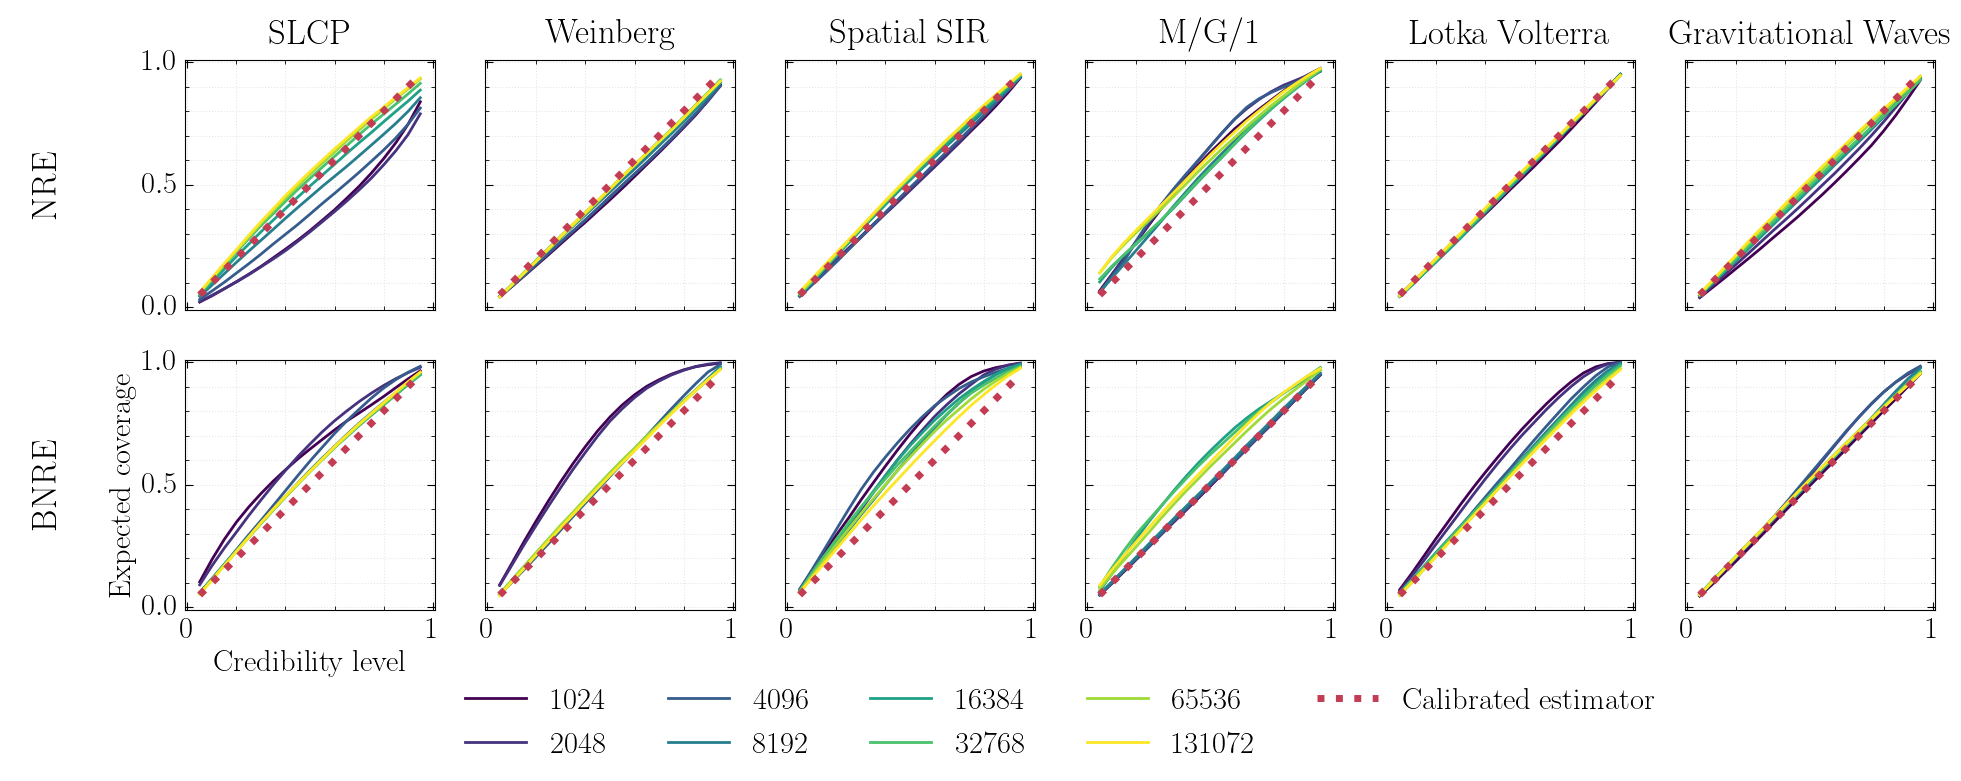

In [24]:
make_coverage_plot_reversed(["nre", "cnre"], "coverage_reversed.pdf")

## Area under expected coverage (above calibrated = +, beneath calibrated = -)

In [25]:
def auec_results(method):
    for problem in problems:
        print(problem)
        print('---\n')
        for budget in simulation_budgets:
            try:
                m, s = area_under_expected_coverage(method, problem, budget)
                print(budget, '\t', m, '\t', s)
            except:
                pass
        print('\n')

In [63]:
def make_coverage_stat_plot(methods, save_name, statistic="auc"):

    # Construct grid
    if statistic == "auc":
        x_offset = 3
        horiz_sizes = [5., 0.1, 0.75, 0.75]
    if statistic == "kstest":
        x_offset = 0
        horiz_sizes = [0.75]
    

    for i in range(len(methods)):
        horiz_sizes += [5., 0.25]
    
    horiz_sizes = horiz_sizes[:-1]

    vert_sizes = [0.75, 1]

    for _ in range(1):
        vert_sizes += [5., 0.5]

    vert_sizes.append(0.75)

    fig = plt.figure(figsize=[sum(horiz_sizes), sum(vert_sizes)])
    horiz = [Fixed(x) for x in horiz_sizes]
    vert = [Fixed(x) for x in vert_sizes]

    rect = (0.1, 0.1, 0.8, 0.8) # Ignored
    divider = Divider(fig, rect, horiz, vert, aspect=False)

    title_size = 25
    


    #Metrics
    for i, method in enumerate(methods):
        ax = fig.add_axes(rect, label="method_axes_{}".format(i))
        ax.set_axes_locator(divider.new_locator(nx=1+x_offset+2*i, ny=3))
        ax.set_axis_off()
        ax.text(0.5, 0.5, method_titles[method], horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontdict = {'fontsize': title_size})

    #Plots
    for i, method in enumerate(methods):
        if i == 0:
            ax = fig.add_axes(rect, label="plot_axes_{}".format(i))
            base_ax = ax
        else:
            ax = fig.add_axes(rect, label="plot_axes_{}".format(i), sharey=base_ax)
            
        ax.set_axes_locator(divider.new_locator(nx=1+x_offset+2*i, ny=2))
        
        for j, problem in enumerate(problems):
            
            #print("method = {}, problem = {}".format(method, problem))
            if statistic == "auc":
                areas = []
                stds = []
                for budget in simulation_budgets:
                    m, s = area_under_expected_coverage(method, problem, budget)
                    if m is None:
                        break
                    areas.append(m)
                    stds.append(s)
                
            if statistic == "kstest":
                areas = []
                for budget in simulation_budgets:
                    m, s = sbc_value(method, problem, budget)
                    if m is None:
                        break
                    areas.append(m)
                    stds.append(s)
                
            if len(areas) != len(simulation_budgets):
                continue

            ax.plot(simulation_budgets, areas, label=problem_titles[problem], color=problem_colors[problem])
            #ax.errorbar(simulation_budgets, areas, yerr=stds, color=problem_colors[problem], alpha=0.3)
                
        
        if statistic == "auc":
            ax.plot([simulation_budgets[0], simulation_budgets[-1]], [0., 0.], ':', color='black', 
                    label="Calibrated estimator")
        if statistic == "kstest":
            ax.set_yscale('log')  
        ax.set_xscale('log')  
        
        if i == 0 :
            ax.set_xlabel("Simulation budget")
            if statistic == "auc":
                ax.set_ylabel("Coverage AUC")
                ax.set_ylim(-0.2, 0.2)
            if statistic == "kstest":
                ax.set_ylabel("KS test p-value")
                ax.set_ylim(1e-5, 1)
            han, l = ax.get_legend_handles_labels()
        else:
            plt.setp(ax.get_yticklabels(), visible=False)

    # Legend
    ax_legend = fig.add_axes(rect, label="legend ax")
    ax_legend.set_axes_locator(divider.new_locator(nx=0, nx1=2*len(methods)+x_offset, ny=0))
    ax_legend.set_axis_off()
    ax_legend.legend(han, l, ncol=4, loc="center")
    
    if statistic == "auc":
        #Demo
        demo_levels = [0.05*i for i in range(0,21)]
        coverages = [0.3*np.sin(level*2*np.pi) + level for level in demo_levels]
        ax = fig.add_axes(rect, label="demo_axes")
        ax.set_axes_locator(divider.new_locator(nx=0, ny=2))
        ax.plot(demo_levels, coverages)
        ax.plot([0, 1], [0, 1], ":", color="tab:gray")
        ax.set_xlabel("Credibility level")
        ax.set_ylabel("Expected coverage")
        ax.fill_between(demo_levels[:11], coverages[:11], y2=demo_levels[:11], zorder=2, fc='c')
        ax.fill_between(demo_levels[10:], coverages[10:], y2=demo_levels[10:], zorder=2, fc='r')
        ax.text(0.3, 0.4, "AUC +", rotation = 45, horizontalalignment='center', verticalalignment='center', 
                fontdict = {'fontsize': 30})
        ax.text(0.75, 0.6, "AUC -", rotation = 45, horizontalalignment='center', verticalalignment='center', 
                fontdict = {'fontsize': 30})

    plt.savefig(save_name)


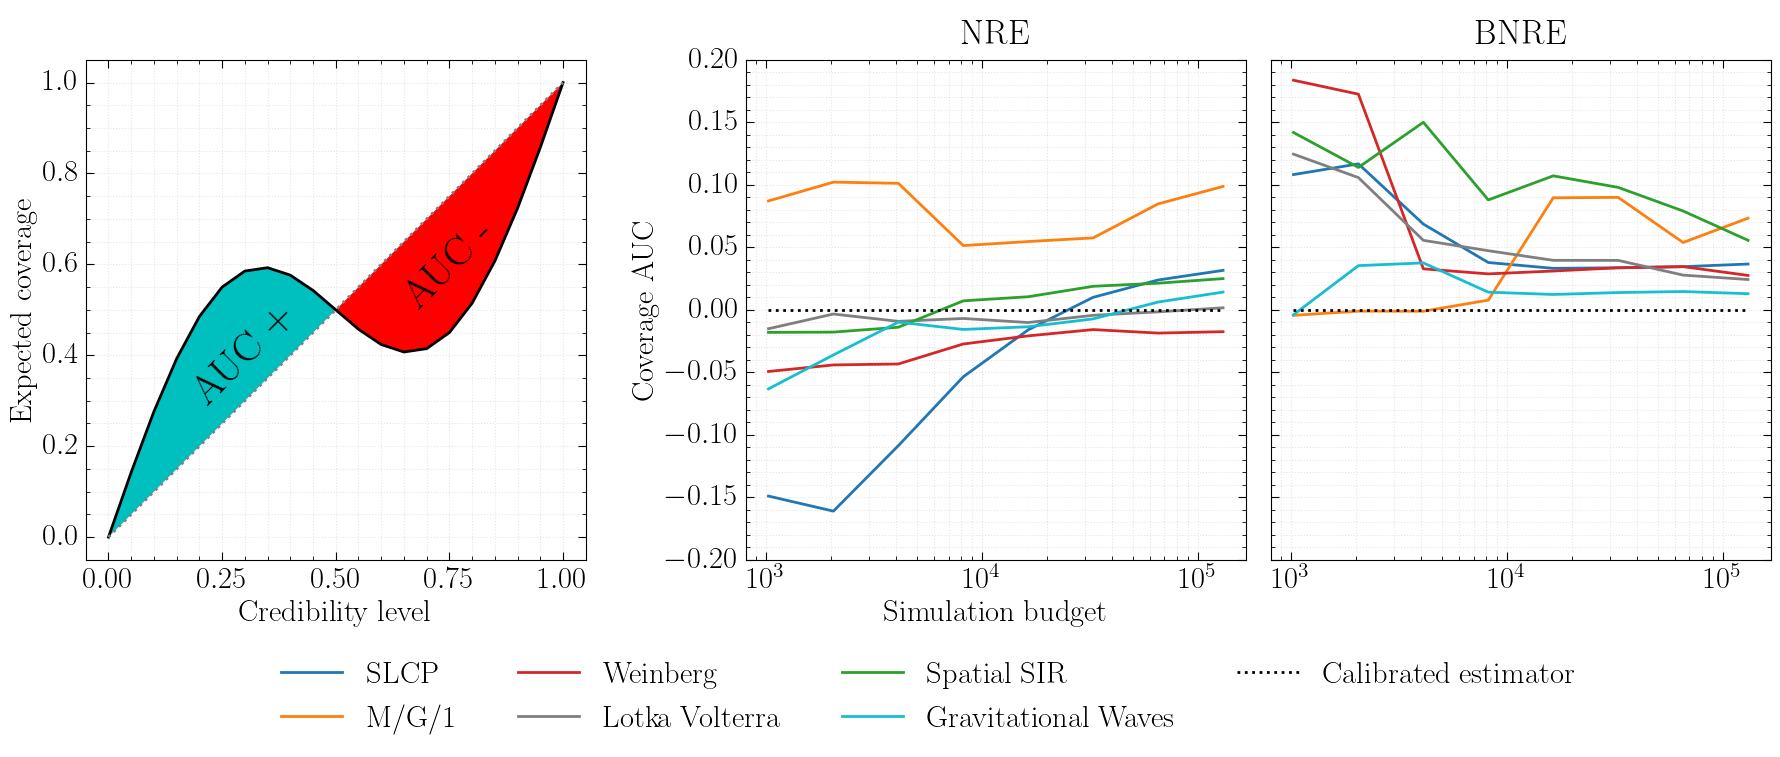

In [64]:
make_coverage_stat_plot(["nre", "cnre"] ,"auc.pdf")

In [104]:
def make_auc_plot_grid(methods, save_name):
    
    plot_problems = ["slcp", "weinberg", "spatialsir", "mg1", "lotka_volterra", "gw"]
    
    # Construct grid
    horiz_sizes = [0.75, 1.]

    for _ in range(len(plot_problems)):
        horiz_sizes += [2.5, 0.5]
    horiz_sizes = horiz_sizes[:-1]

    vert_sizes = [0.75, 0.75]

    for _ in range(len(methods)):
        vert_sizes += [2.5, 0.5]

    vert_sizes.append(0.75)

    fig = plt.figure(figsize=[sum(horiz_sizes), sum(vert_sizes)])
    horiz = [Fixed(x) for x in horiz_sizes]
    vert = [Fixed(x) for x in vert_sizes]

    rect = (0.1, 0.1, 0.8, 0.8) # Ignored
    divider = Divider(fig, rect, horiz, vert, aspect=False)

    title_size = 25

    #Problems
    
    for i in range(len(plot_problems)):
        ax = fig.add_axes(rect, label="problem_axes_{}".format(i))
        ax.set_axes_locator(divider.new_locator(nx=2+2*i, ny=2*len(methods)+1))
        ax.set_axis_off()
        ax.text(0.5, 0.5, problem_titles[plot_problems[i]], horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontdict = {'fontsize': title_size})
    
    #Metrics
    for i, method in enumerate(methods):
        ax = fig.add_axes(rect, label="method_axes_{}".format(i))
        ax.set_axes_locator(divider.new_locator(nx=0, ny=2*(len(methods))-2*i))
        ax.set_axis_off()
        ax.text(0.5, 0.5, method_titles[method], horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontdict = {'fontsize': title_size}, rotation=90)
    

    #Plots
    for i, method in enumerate(methods):
        for j, problem in enumerate(plot_problems):
            if i == 0 and j == 0:
                ax = fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j))
                base_ax = ax
            else:
                ax = fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j), sharey=base_ax)
                
            ax.set_axes_locator(divider.new_locator(nx=2+2*j, ny=2*len(methods)-2*i))
            areas = []
            stds = []
            for budget in simulation_budgets:
                m, s = area_under_expected_coverage(method, problem, budget)
                if m is None:
                    break
                areas.append(m)
                stds.append(s)
            
            areas = np.array(areas)
            stds = np.array(stds)
            
            ax.plot(simulation_budgets, areas, label=problem_titles[problem], color=problem_colors[problem])
            ax.fill_between(simulation_budgets, y1=areas-stds, y2=areas+stds, color=problem_colors[problem], alpha=0.3)
            ax.plot([simulation_budgets[0], simulation_budgets[-1]], [0., 0.], ':', color='black', 
                    label="Calibrated estimator")
            
            ax.set_xscale('log')
            ax.set_ylim(-0.2, 0.2)
            
            if i == 0 and j == 0:
                han, l = ax.get_legend_handles_labels()
            if i == len(methods)-1 and j == 0:
                ax.set_xlabel("Simulation budget")
                ax.set_ylabel("Coverage AUC")
                
            if j != 0:
                plt.setp(ax.get_yticklabels(), visible=False)
            if i != len(methods)-1:
                plt.setp(ax.get_xticklabels(), visible=False)


    plt.savefig(save_name)

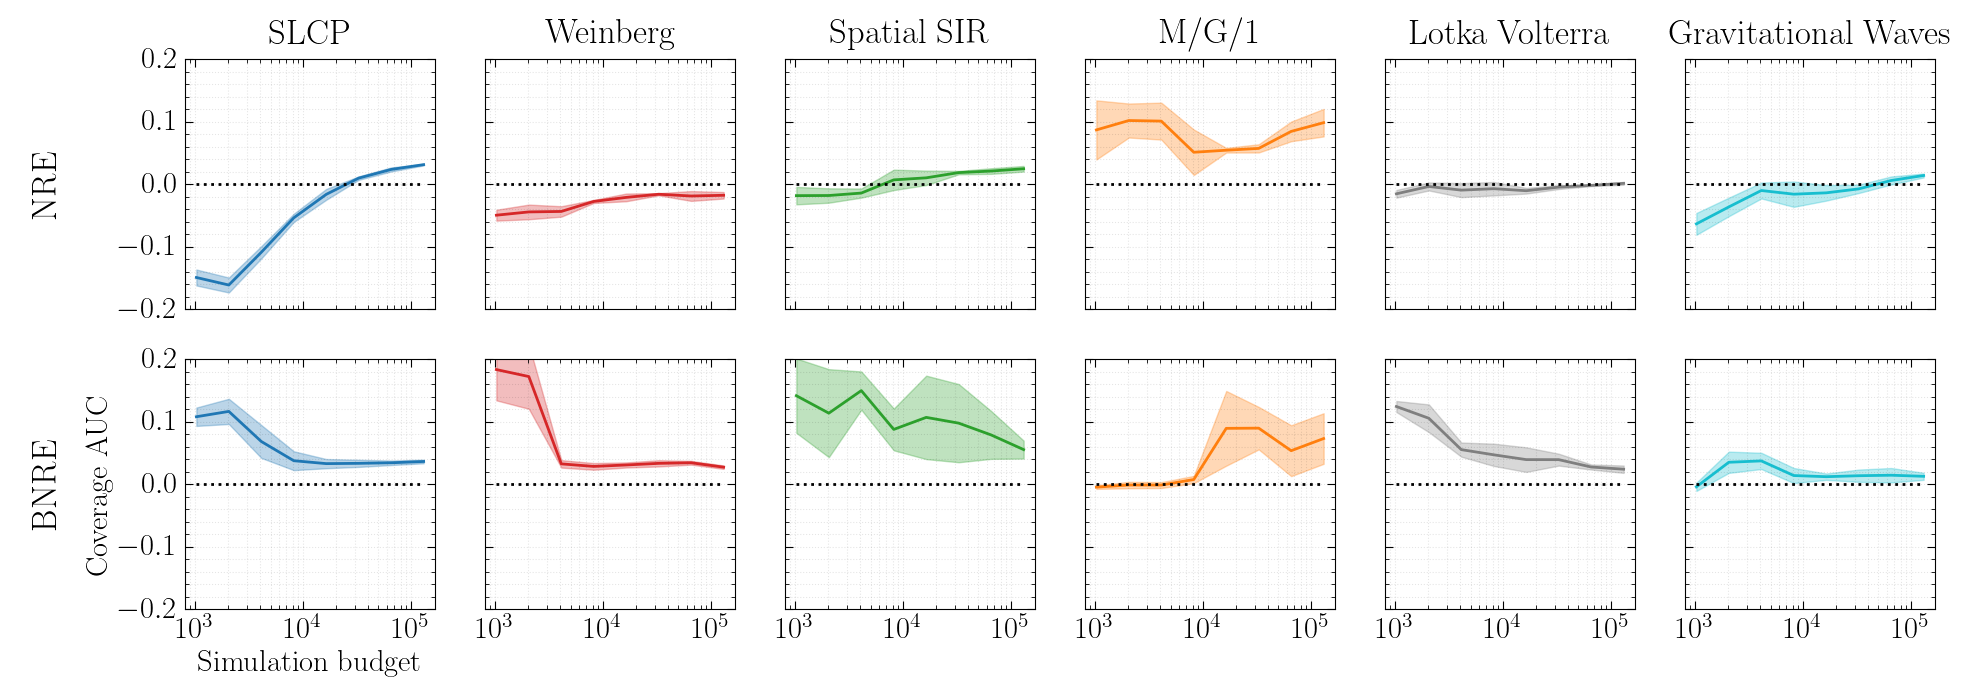

In [105]:
make_auc_plot_grid(["nre", "cnre"], "auc_grid.pdf")

In [ ]:
demo_levels = [0.05*i for i in range(0,21)]
#coverages = [np.sqrt(1 - (1-level)**2) for level in demo_levels]
coverages = [0.3*np.sin(level*2*np.pi) + level for level in demo_levels]
plt.plot(demo_levels, coverages)
plt.plot([0, 1], [0, 1], ":", color="tab:gray")
plt.xlabel("Level")
plt.ylabel("Coverage")
#plt.fill_between(demo_levels, coverages, y2=demo_levels, hatch='\\', zorder=2, fc='c')
plt.fill_between(demo_levels[:11], coverages[:11], y2=demo_levels[:11], zorder=2, fc='c')
plt.fill_between(demo_levels[10:], coverages[10:], y2=demo_levels[10:], zorder=2, fc='r')
#plt.text(0.4, 0.6, "Coverage auc", rotation = 45, horizontalalignment='center', verticalalignment='center', 
#         fontdict = {'fontsize': 30})
plt.text(0.3, 0.4, "AUC +", rotation = 45, horizontalalignment='center', verticalalignment='center', 
         fontdict = {'fontsize': 30})
plt.text(0.7, 0.6, "AUC -", rotation = 45, horizontalalignment='center', verticalalignment='center', 
         fontdict = {'fontsize': 30})

plt.savefig("auc_demo.pdf")

## SBC

In [ ]:
def sbc_value(method, problem, simulations):
    TOT_SAMPLES = 10000
    
    method_name = method.split(' ')[0]
    if method_name == 'npe':
        query = '/scratch/projects/casbi/workflows/coverage_simulations_and_bias_reduction/' + problem + '/output/' + str(simulations) + '/without-regularization/'
        if 'ensemble' not in method:
            query += '/flow-sbi-0*/coverage.npy'
        else:
            query += '/coverage-flow-sbi.npy'
    else:
        query = '../' + method_name + '/' + problem + '/output/estimator/' + str(simulations) + '/' + batch_size + '/' + problem_lrs[problem]
        if 'ensemble' not in method:
            query += '/*/coverage.npy'
        else:
            query += '/coverage.npy'
    files = glob.glob(query)
    if len(files) == 0:
        return None, None
    
    p_values = []
    for f in files:
        cov = np.load(f)
        if method != "npe":
            cov = np.flip(cov)
        #prop_samples [i] = prop of samples that are ranked between i*0.05 and (i+1)*0.05
        prop_samples = np.zeros((20,))
        prop_samples[0] = cov[0]
        for i in range(1,19):
            prop_samples[i] = cov[i] - cov[i-1]
        prop_samples[19] = 1 - cov[18]
        
        nb_samples = prop_samples * TOT_SAMPLES
        nb_samples = nb_samples.astype(np.int32)
        
        ranks = np.concatenate([np.random.uniform(low=i*0.05, high=(i+1)*0.05, size=(nb_sample,)) 
                                for i, nb_sample in enumerate(nb_samples)])

        p_value = kstest(ranks, uniform(loc=0, scale=1).cdf)[1]
        p_values.append(p_value)
        
    return np.mean(p_values), np.std(p_values)

In [ ]:
def plot_sbc(method, problem, ax=None):
    if ax is None:
        ax = plt.gca()
        ax.set_xlabel('Simulation budget')
        ax.set_title(method_titles[method])
        
    data = [sbc_value(method, problem, sim)[0] for sim in simulation_budgets]
    if len(data) == len(simulation_budgets):
        ax.plot(simulation_budgets, data, label=problem_titles[problem])
        
    ax.set_xscale('log')

In [ ]:
plot_sbc("cnre", "lotka_volterra")

In [ ]:
make_coverage_stat_plot(["npe", "nre", "cnre", "ratio_npe", "ratio_cnpe"] ,"sbc.pdf", statistic="kstest")

### C-NRE

In [ ]:
auec_results('cnre')

### C-NRE ensemble

In [ ]:
auec_results('cnre ensemble')

### NRE

In [ ]:
auec_results('nre')

### NRE ensemble

In [ ]:
auec_results('nre ensemble')

### NPE

In [ ]:
auec_results('npe')

### NPE ensemble

In [ ]:
auec_results('npe ensemble')

## Metrics

### C-NRE

In [ ]:
for problem in problems:
    print(problem)
    print("--")
    learning_rate = problem_lrs[problem]
    for budget in simulation_budgets:
        # Balancing condition
        conditions_met = True
        paths = glob.glob(problem + '/output/estimator/' + str(budget) + '/' + batch_size + '/' + learning_rate + '/*/balancing.npy')
        balancing_values = [np.load(p) for p in paths]
        if len(balancing_values) < 2:
            continue
        balancing = np.mean(balancing_values)
        balanced = np.abs(balancing - 1) <= 0.01
        conditions_met &= balanced
        # E_marginals[rhat]
        paths = glob.glob(problem + '/output/estimator/' + str(budget) + '/' + batch_size + '/' + learning_rate + '/*/marginal_rhat.npy')
        rhat_values = [np.load(p) for p in paths]
        if len(rhat_values) < 2:
            continue
        marginals_rhat = np.mean(rhat_values)
        conditions_met &= (marginals_rhat <= 1.001)
        # Output
        print('> ', budget, '\t', balancing, '+-', np.std(balancing_values), '\t', balanced, '\t', marginals_rhat, '+-', np.std(rhat_values), '\t', conditions_met)
    print('\n')

### NRE

In [ ]:
for problem in problems:
    print(problem)
    print("--")
    learning_rate = problem_lrs[problem]
    for budget in simulation_budgets:
        # Balancing condition
        conditions_met = True
        paths = glob.glob('../nre/' + problem + '/output/estimator/' + str(budget) + '/' + batch_size + '/' + learning_rate + '/*/balancing.npy')
        balancing_values = [np.load(p) for p in paths]
        if len(balancing_values) < 2:
            continue
        balancing = np.mean(balancing_values)
        balanced = np.abs(balancing - 1) <= 0.01
        conditions_met &= balanced
        # E_marginals[rhat]
        paths = glob.glob('../nre/' + problem + '/output/estimator/' + str(budget) + '/' + batch_size + '/' + learning_rate + '/*/marginal_rhat.npy')
        rhat_values = [np.load(p) for p in paths]
        if len(rhat_values) < 2:
            continue
        marginals_rhat = np.mean(rhat_values)
        conditions_met &= (marginals_rhat <= 1.001)
        # Output
        print('> ', budget, '\t', balancing, '+-', np.std(balancing_values), '\t', balanced, '\t', marginals_rhat, '+-', np.std(rhat_values), '\t', conditions_met)
    print('\n')

## Mutual information plot

In [ ]:
nrows = 6
ncols = 4
res = 5
fig, axes = plt.subplots(nrows, ncols, figsize=(res * nrows, res * ncols))

# Plot results
for index, problem in enumerate(problems):
    axes[index][0].set_ylabel(problem_titles[problem])
    plot_mi_problem(axes[index], problem)

plt.show()

## Contour area distributions

In [ ]:
show_levels = [0.95]

### NRE

In [ ]:
for problem in problems:
    print(problem)
    print('---')
    for level_index, level in enumerate(levels):
        if level not in show_levels:
            continue
        for budget_index, budget in enumerate(simulation_budgets):
            query = '../nre/' + problem + '/output/estimator/' + str(budget) + '/' + batch_size + '/' + learning_rate + '/*/contour-sizes.npy'
            files = glob.glob(query)
            if len(files) == 0:
                continue
            samples = np.hstack([np.flip(np.load(f))[level_index].reshape(-1) for f in files])
            plt.hist(samples, bins=100, density=False, cumulative=False, histtype='step', lw=2, label=budget, color=colors[budget_index])
        plt.title(problem_titles[problem] + r'$~\alpha~=~$' + '{:.2f}'.format(levels[level_index]))
        plt.legend()
        plt.show()
    print('\n')

### NRE ensemble

In [ ]:
for problem in problems:
    print(problem)
    print('---')
    for level_index, level in enumerate(levels):
        if level not in show_levels:
            continue
        for budget_index, budget in enumerate(simulation_budgets):
            query = '../nre/' + problem + '/output/estimator/' + str(budget) + '/' + batch_size + '/' + learning_rate + '/contour-sizes.npy'
            files = glob.glob(query)
            if len(files) == 0:
                continue
            samples = np.hstack([np.flip(np.load(f))[level_index].reshape(-1) for f in files])
            plt.hist(samples, bins=100, density=False, cumulative=False, histtype='step', lw=2, label=budget, color=colors[budget_index])
        plt.title(problem_titles[problem] + r'$~\alpha~=~$' + '{:.2f}'.format(levels[level_index]))
        plt.legend()
        plt.show()
    print('\n')

### C-NRE

In [ ]:
for problem in problems:
    print(problem)
    print('---')
    for level_index, level in enumerate(levels):
        if level not in show_levels:
            continue
        for budget_index, budget in enumerate(simulation_budgets):
            query = problem + '/output/estimator/' + str(budget) + '/' + batch_size + '/' + learning_rate + '/*/contour-sizes.npy'
            files = glob.glob(query)
            if len(files) == 0:
                continue
            samples = np.hstack([np.flip(np.load(f))[level_index].reshape(-1) for f in files])
            plt.hist(samples, bins=75, density=False, cumulative=False, histtype='step', lw=2, label=budget, color=colors[budget_index])
        plt.title(problem_titles[problem] + r'$~\alpha~=~$' + '{:.2f}'.format(levels[level_index]))
        plt.legend()
        plt.show()
    print('\n')

### C-NRE ensemble

In [ ]:
for problem in problems:
    print(problem)
    print('---')
    for level_index, level in enumerate(levels):
        if level not in show_levels:
            continue
        for budget_index, budget in enumerate(simulation_budgets):
            query = problem + '/output/estimator/' + str(budget) + '/' + batch_size + '/' + learning_rate + '/contour-sizes.npy'
            files = glob.glob(query)
            if len(files) == 0:
                continue
            samples = np.hstack([np.flip(np.load(f))[level_index].reshape(-1) for f in files])
            plt.hist(samples, bins=40, density=False, cumulative=False, histtype='step', lw=2, label=budget, color=colors[budget_index])
        plt.title(problem_titles[problem] + r'$~\alpha~=~$' + '{:.2f}'.format(levels[level_index]))
        plt.legend()
        plt.show()
    print('\n')

## Evolution of contour size

### Utilities

In [ ]:
def load_contour_size_data(problem, nre=False):
    if nre:
        problem = '../nre/' + problem
    data = [[] for _ in range(len(levels))]
    data_ensemble = [[] for _ in range(len(levels))]
    for budget in simulation_budgets:
        for level_index, level in enumerate(levels):
            # Ensemble
            query = problem + '/output/estimator/' + str(budget) + '/' + batch_size + '/' + learning_rate + '/contour-sizes.npy'
            files = glob.glob(query)
            if len(files) == 0:
                continue
            samples = np.hstack([np.flip(np.load(f))[level_index].reshape(-1) for f in files])
            m = np.median(samples)
            data_ensemble[level_index].append(m)
            # Individual
            query = problem + '/output/estimator/' + str(budget) + '/' + batch_size + '/' + learning_rate + '/*/contour-sizes.npy'
            files = glob.glob(query)
            if len(files) == 0:
                continue
            samples = np.hstack([np.flip(np.load(f))[level_index].reshape(-1) for f in files])
            m = np.median(samples)
            data[level_index].append(m)
            
    return data, data_ensemble

In [ ]:
def plot_contour_size(problem, ax=None, nre=False):
    if ax is None:
        ax = plt.gca()
    data, data_ensemble = load_contour_size_data(problem, nre=nre)
    for level_index, _ in enumerate(levels):
        if len(data[level_index]) == len(simulation_budgets):
            ax.plot(simulation_budgets, data[level_index], c=colors_levels[level_index])
        if len(data[level_index]) == len(simulation_budgets):
            ax.plot(simulation_budgets, data_ensemble[level_index], ':', c=colors_levels[level_index])
    ax.set_xscale('log')
    ax.set_xlabel('Simulation budget')
    ax.set_ylabel('Relative contour size')
    ax.set_title(problem_titles[problem])
    ax.set_ylim([0 - 0.05, 1 + 0.05])
    make_square(ax)

### Plots

In [ ]:
for problem in problems:
    try:
        plot_contour_size(problem)
        plt.show()
    except:
        pass

In [ ]:
for problem in problems:
    try:
        plot_contour_size(problem, nre=True)
        plt.show()
    except Exception as e:
        print(e)

## Bias/variance

### Utilities

In [51]:
def load_bias_variance(problem, method, metric, metric_index, gamma=None, schedule=False):
    learning_rate = problem_lrs[problem]

    data = []
    data_ensemble = []
    stds = []
    for budget in simulation_budgets:
        # Ensemble
        base_query = '../{}/'.format(method) + problem + '/output/estimator/' + str(budget) + '/' + batch_size + '/' + learning_rate
        if gamma is not None:
            base_query += '/' + str(gamma)
        if schedule:
            base_query += '/schedule'
        query = base_query + '/{}.npy'.format(metric)
        
        files = glob.glob(query)
        if len(files) != 0:
            samples = np.hstack([np.load(f)[metric_index].reshape(-1) for f in files])
            m = np.median(samples)
            data_ensemble.append(m)
        
        # Individual
        query = base_query + '/*/{}.npy'.format(metric)
        
        files = glob.glob(query)
        if len(files) != 0:

            samples = np.hstack([np.load(f)[metric_index].reshape(-1) for f in files])
            m = np.median(samples)
            data.append(m)
            s = np.std(samples)
            stds.append(s)
        
    scale = problem_scales[problem][metric_index]
        
    data = np.array(data)
    stds = np.array(stds)
    data_ensemble = np.array(data_ensemble)

    if metric == "bias":
        data /= scale
        data_ensemble /= scale
        stds /= scale

    if metric == "bias_square" or metric == "variance":
        data /= scale**2
        data_ensemble /= scale**2
        stds /= scale**2
            
    return data, data_ensemble, stds

In [71]:
def plot_bias_variance(problem, method, metric, metric_index, ax=None):
    if ax is None:
        ax = plt.gca()
        ax.set_xlabel('Simulation budget')
        #ax.set_ylabel("{}_{}".format(metric, metric_index))
        ax.set_title(problem_titles[problem])
        
    data, data_ensemble, stds = load_bias_variance(problem, method, metric, metric_index)
    if len(data) == len(simulation_budgets):
        ax.plot(simulation_budgets, data, color=method_colors[method], label=method_titles[method])
        #ax.errorbar(simulation_budgets, data, yerr=stds, color=method_colors[method], alpha=0.3)
        ax.fill_between(simulation_budgets, y1=data-stds, y2=data+stds, color=method_colors[method], alpha=0.1)
    """
    if len(data) == len(simulation_budgets):
        ax.plot(simulation_budgets, data_ensemble, ':', label="Ensemble")
    """
    ax.set_xscale('log')
    make_square(ax)

### Plots

In [ ]:
plot_bias_variance("slcp", "nre", "bias", 0)

In [ ]:
plot_bias_variance("lotka_volterra", "cnre", "bias", 0)

In [ ]:
# Construct grid
horiz_sizes = [0.75, 0.75]

for _ in range(6):
    horiz_sizes += [2.5, 1.]
horiz_sizes = horiz_sizes[:-1]

vert_sizes = [0.75, 0.5]

for _ in range(6):
    vert_sizes += [2.5, 0.5]

vert_sizes.append(0.75)

fig = plt.figure(figsize=[sum(horiz_sizes), sum(vert_sizes)])
horiz = [Fixed(x) for x in horiz_sizes]
vert = [Fixed(x) for x in vert_sizes]

rect = (0.1, 0.1, 0.8, 0.8) # Ignored
divider = Divider(fig, rect, horiz, vert, aspect=False)

title_size = 25

#Problems
for i in range(6):
    ax = fig.add_axes(rect, label="problem_axes_{}".format(i))
    ax.set_axes_locator(divider.new_locator(nx=0, ny=12-2*i))
    ax.set_axis_off()
    ax.text(0.5, 0.5, problem_titles[problems[i]], horizontalalignment='center', verticalalignment='center', 
            transform=ax.transAxes, fontdict = {'fontsize': title_size}, rotation=90)

#Metrics
for i in range(3):
    ax = fig.add_axes(rect, label="metric_axes_{}".format(i))
    ax.set_axes_locator(divider.new_locator(nx=2+2*i, ny=14))
    ax.set_axis_off()
    ax.text(0.5, 0.5, "Bias {}".format(i+1), horizontalalignment='center', verticalalignment='center', 
            transform=ax.transAxes, fontdict = {'fontsize': title_size})

    ax = fig.add_axes(rect, label="metric_axes_{}".format(3+i))
    ax.set_axes_locator(divider.new_locator(nx=8+2*i, ny=14))
    ax.set_axis_off()
    ax.text(0.5, 0.5, "Variance {}".format(i+1), horizontalalignment='center', verticalalignment='center', 
            transform=ax.transAxes, fontdict = {'fontsize': title_size})
    
#Plots
for i, problem in enumerate(problems):
    for j in range(problem_nb_params[problem]):
        #Bias
        ax = fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j))
        ax.set_axes_locator(divider.new_locator(nx=2+2*j, ny=12-2*i))
        for method in methods:
            plot_bias_variance(problem, method, "bias_square", j, ax=ax)
        
        if i == 0 and j == 0:
            han, l = ax.get_legend_handles_labels()
        
        #Variance
        ax = fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j+3))
        ax.set_axes_locator(divider.new_locator(nx=8+2*j, ny=12-2*i))
        for method in methods:
            plot_bias_variance(problem, method, "variance", j, ax=ax)
        
# Legend
ax_legend = fig.add_axes(rect, label="legend ax")
ax_legend.set_axes_locator(divider.new_locator(nx=2, nx1=12, ny=0))
ax_legend.set_axis_off()
ax_legend.legend(han, l, ncol=2, loc="center")

plt.savefig("bias_variance.pdf")

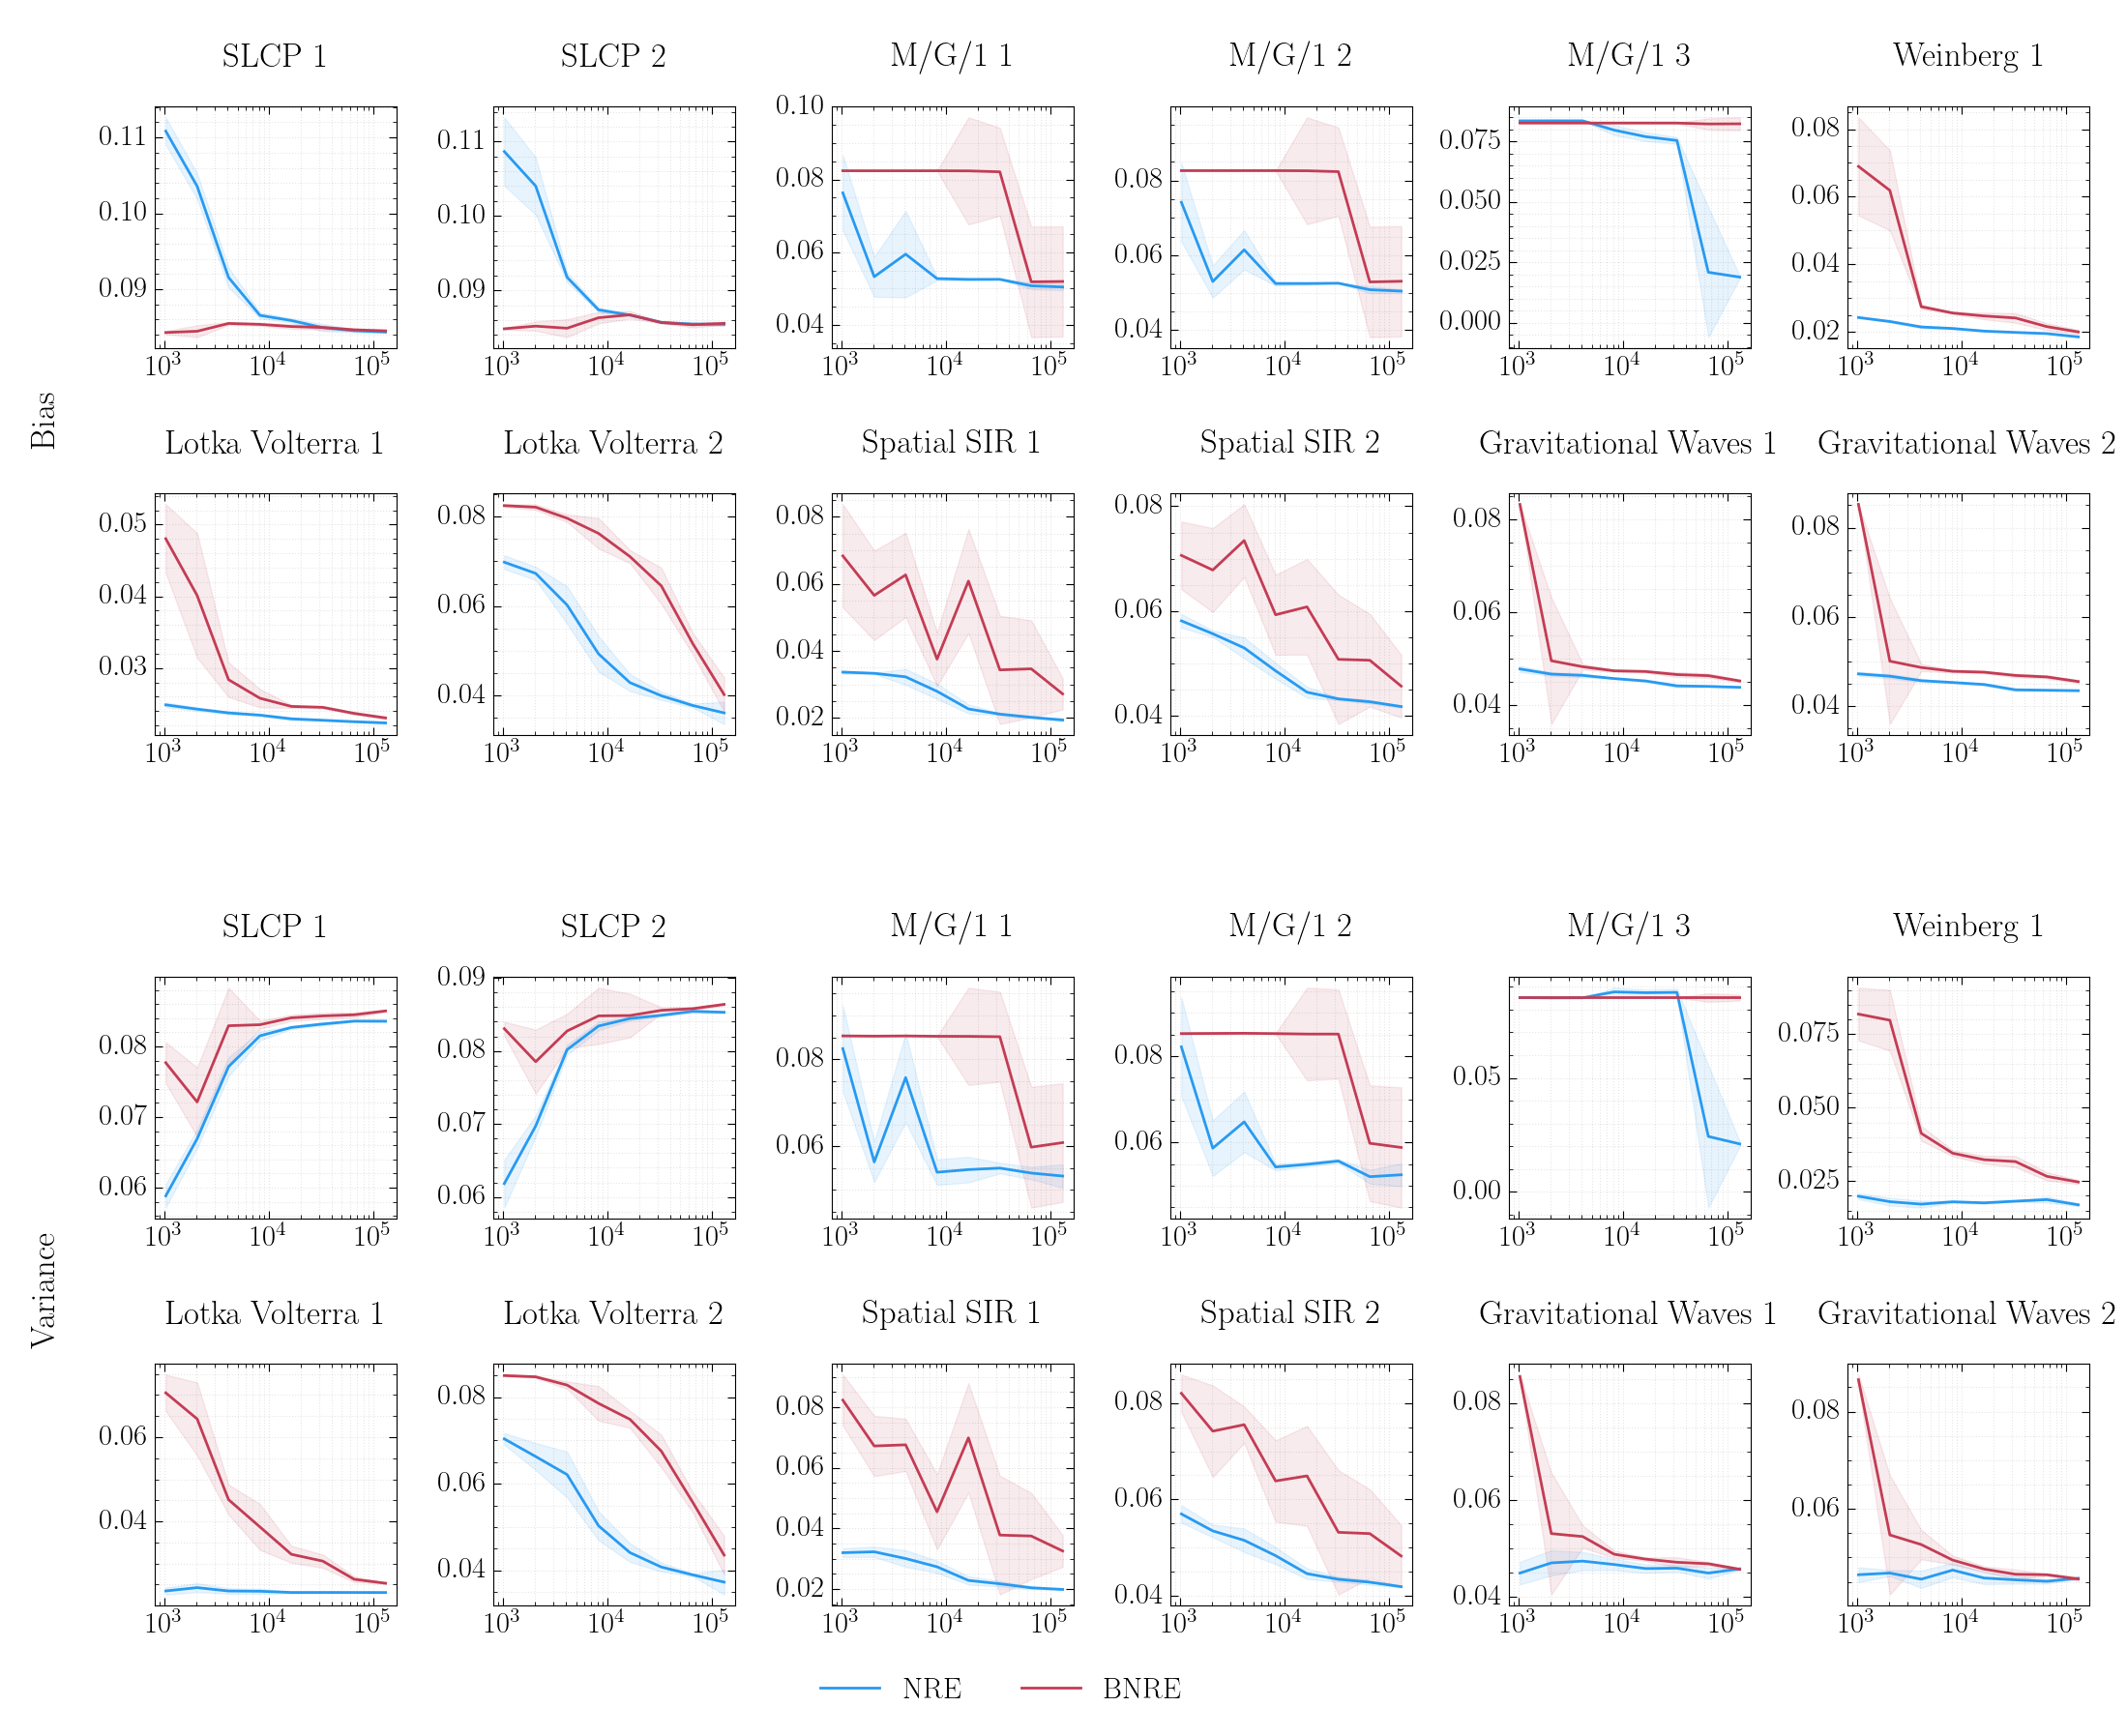

In [88]:
# Construct grid
horiz_sizes = [0.75, 0.75]

for _ in range(6):
    horiz_sizes += [2.5, 1.]
horiz_sizes = horiz_sizes[:-1]

vert_sizes = [0.75, 0.5]

for i in range(4):
    if i == 1:
        vert_sizes += [2.5, 1., 1.5]
    else:
        vert_sizes += [2.5, 1., 0.5]

vert_sizes.append(0.75)

fig = plt.figure(figsize=[sum(horiz_sizes), sum(vert_sizes)])
horiz = [Fixed(x) for x in horiz_sizes]
vert = [Fixed(x) for x in vert_sizes]

rect = (0.1, 0.1, 0.8, 0.8) # Ignored
divider = Divider(fig, rect, horiz, vert, aspect=False)

title_size = 25

#Metrics 
ax = fig.add_axes(rect, label="bias_axes")
ax.set_axes_locator(divider.new_locator(nx=0, ny=8, ny1=12))
ax.set_axis_off()
ax.text(0.5, 0.5, "Bias", horizontalalignment='center', verticalalignment='center', 
            transform=ax.transAxes, fontdict = {'fontsize': title_size}, rotation=90)
ax = fig.add_axes(rect, label="variance_axes")
ax.set_axes_locator(divider.new_locator(nx=0, ny=2, ny1=6))
ax.set_axis_off()
ax.text(0.5, 0.5, "Variance", horizontalalignment='center', verticalalignment='center', 
            transform=ax.transAxes, fontdict = {'fontsize': title_size}, rotation=90)

#Plots
curr_index = 0
for i, problem in enumerate(problems):
    for j in range(problem_nb_params[problem]):
        #Bias
        ax = fig.add_axes(rect, label="plot_axes_bias_{}_{}".format(i, j))
        ax.set_axes_locator(divider.new_locator(nx=2+2*(curr_index%6), ny=11-3*(curr_index//6)))
        #for method in methods:
        for method in ["nre", "cnre"]:
            plot_bias_variance(problem, method, "bias_square", j, ax=ax)
        
        if curr_index == 0:
            han, l = ax.get_legend_handles_labels()
        
        ax = fig.add_axes(rect, label="title_axes_bias_{}_{}".format(i, j))
        ax.set_axes_locator(divider.new_locator(nx=2+2*(curr_index%6), ny=12-3*(curr_index//6)))
        ax.set_axis_off()
        ax.text(0.5, 0.5, "{} {}".format(problem_titles[problem], j+1), horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes, fontdict = {'fontsize': title_size})
        
        
        #Variance
        ax = fig.add_axes(rect, label="plot_axes_variance_{}_{}".format(i, j))
        ax.set_axes_locator(divider.new_locator(nx=2+2*(curr_index%6), ny=5-3*(curr_index//6)))
        #for method in methods:
        for method in ["nre", "cnre"]:
            plot_bias_variance(problem, method, "variance", j, ax=ax)
        
        ax = fig.add_axes(rect, label="title_axes_variance_{}_{}".format(i, j))
        ax.set_axes_locator(divider.new_locator(nx=2+2*(curr_index%6), ny=6-3*(curr_index//6)))
        ax.set_axis_off()
        ax.text(0.5, 0.5, "{} {}".format(problem_titles[problem], j+1), horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes, fontdict = {'fontsize': title_size})
        
        curr_index += 1

        
# Legend
ax_legend = fig.add_axes(rect, label="legend ax")
ax_legend.set_axes_locator(divider.new_locator(nx=2, nx1=12, ny=0))
ax_legend.set_axis_off()
ax_legend.legend(han, l, ncol=6, loc="center")

plt.savefig("bias_variance.pdf")

## Log posterior

In [59]:
def load_log_posterior(problem, method, gamma=None, schedule=False):
    learning_rate = problem_lrs[problem]

    data = []
    stds = []
    for budget in simulation_budgets:
        base_query = '../{}/'.format(method) + problem + '/output/estimator/' + str(budget) + '/' + batch_size + '/' + learning_rate
        if gamma is not None:
            base_query += '/' + str(gamma)
        if schedule:
            base_query += '/schedule'

        query = base_query + "/*/log_posterior.npy"
        
        files = glob.glob(query)
        if len(files) != 0:
            samples = np.hstack([np.load(f).reshape(-1) for f in files])
            m = np.median(samples)
            data.append(m)
            s = np.std(samples)
            stds.append(s)
        
    data = np.array(data)
    stds = np.array(stds)
            
    return data, stds

In [73]:
def plot_log_posterior(problem, method, ax=None):
    if ax is None:
        ax = plt.gca()
        ax.set_xlabel('Simulation budget')
        ax.set_title(problem_titles[problem])
        
    data, stds = load_log_posterior(problem, method)
    if len(data) == len(simulation_budgets):
        ax.plot(simulation_budgets, data, method_colors[method], label=method_titles[method])
        #ax.errorbar(simulation_budgets, data, yerr=stds, color="k", alpha=0.3)
        ax.fill_between(simulation_budgets, y1=data-stds, y2=data+stds, color=method_colors[method], alpha=0.1)
   
    ax.set_xscale('log')
    make_square(ax)

In [84]:
def make_log_posterior_plot(methods, save_name):
    
    plot_problems = ["slcp", "weinberg", "spatialsir", "mg1", "lotka_volterra", "gw"]
    
    # Construct grid
    horiz_sizes = []

    for _ in range(len(plot_problems)):
        horiz_sizes += [2.5, 0.5]
    horiz_sizes = horiz_sizes[:-1]

    vert_sizes = [0.75, 0.5]

    vert_sizes += [2.5, 0.25]

    vert_sizes.append(0.75)

    fig = plt.figure(figsize=[sum(horiz_sizes), sum(vert_sizes)])
    horiz = [Fixed(x) for x in horiz_sizes]
    vert = [Fixed(x) for x in vert_sizes]

    rect = (0.1, 0.1, 0.8, 0.8) # Ignored
    divider = Divider(fig, rect, horiz, vert, aspect=False)

    title_size = 25

    #Problems
    
    for i in range(len(plot_problems)):
        ax = fig.add_axes(rect, label="problem_axes_{}".format(i))
        ax.set_axes_locator(divider.new_locator(nx=2*i, ny=4))
        ax.set_axis_off()
        ax.text(0.5, 0.5, problem_titles[plot_problems[i]], horizontalalignment='center', verticalalignment='center', 
                transform=ax.transAxes, fontdict = {'fontsize': title_size})
    
    #Plots
    for j, problem in enumerate(plot_problems):
        ax = fig.add_axes(rect, label="plot_axes_{}_{}".format(i, j))
        ax.set_axes_locator(divider.new_locator(nx=2*j, ny=2))
        for i, method in enumerate(methods):
            plot_log_posterior(problem, method, ax)
        
        log_prior = np.log(1/np.prod(np.array(problem_scales[problem])))
        ax.plot(simulation_budgets, [log_prior for _ in simulation_budgets], color="C0", linestyle='-', 
                label="Prior")

        if j == 0:
            ax.set_xlabel("Simulation budget")
            #ax.set_ylabel(r"$\mathbb{E}_{p(\boldsymbol{\vartheta},\boldsymbol{x})}\left[\log \hat{p}(\boldsymbol{\vartheta}|\boldsymbol{x})\right]$")
            ax.set_ylabel(r"$\mathbb{E}_{p(\vartheta,x)}\left[\log \hat{p}(\vartheta|x)\right]$")
            #ax.set_ylabel("Log posterior density")
            han, l = ax.get_legend_handles_labels()
    

    # Legend
    ax_legend = fig.add_axes(rect, label="legend ax")
    ax_legend.set_axes_locator(divider.new_locator(nx=0, nx1=2*len(plot_problems)-1, ny=0))
    ax_legend.set_axis_off()
    ax_legend.legend(han, l, ncol=3, loc="center")

    plt.savefig(save_name)

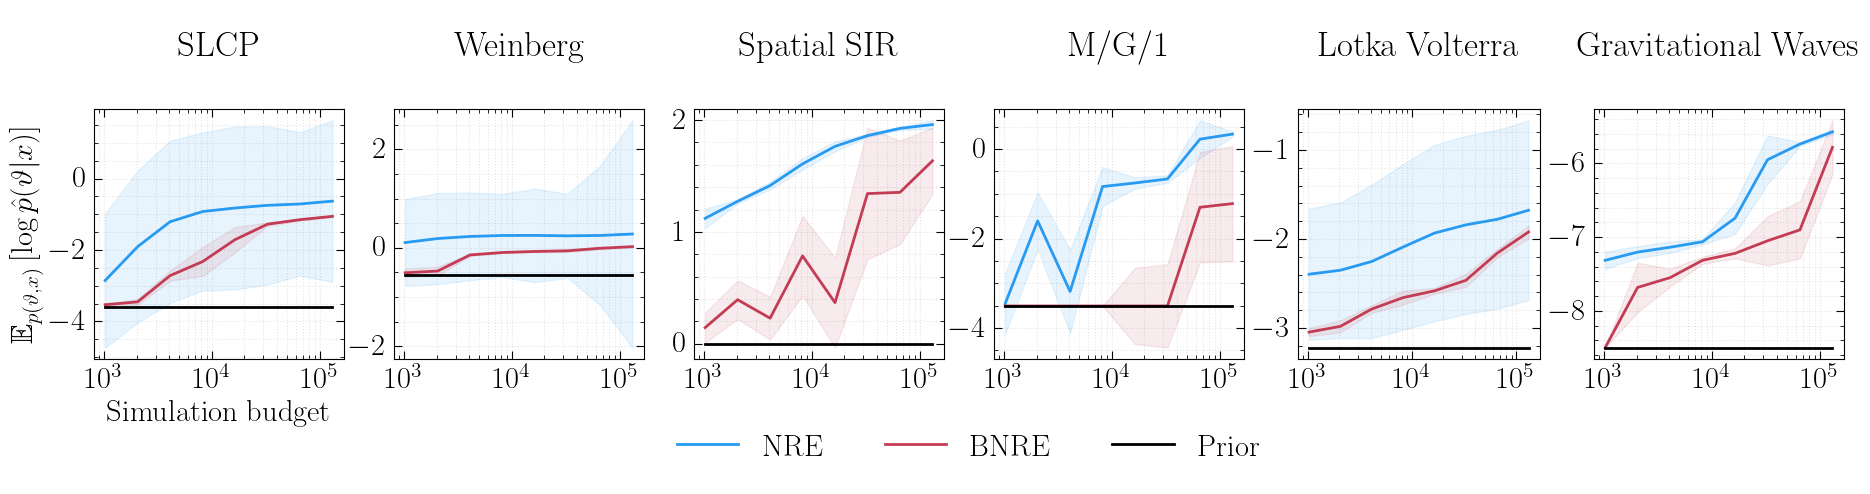

In [89]:
make_log_posterior_plot(["nre", "cnre"], "log_posterior.pdf")

## illustrative summary

In [61]:
def make_illustrative_summary(save_name):
    
    # Construct grid
    horiz_sizes = [3.5, 0.75, 3.5, 2., 3.5, 0.75, 3.5]

    vert_sizes = [0.75, 1.25, 3.5, 0.25, 0.5]

    fig = plt.figure(figsize=[sum(horiz_sizes), sum(vert_sizes)])
    horiz = [Fixed(x) for x in horiz_sizes]
    vert = [Fixed(x) for x in vert_sizes]

    rect = (0.1, 0.1, 0.8, 0.8) # Ignored
    divider = Divider(fig, rect, horiz, vert, aspect=False)

    title_size = 25
    
    #Coverages
    ax_cov_nre = fig.add_axes(rect, label="ax_cov_nre")
    ax_cov_nre.set_axes_locator(divider.new_locator(nx=0, ny=2))
    method_plot_functions["nre"]("weinberg", ax_cov_nre)
    ax_cov_nre.plot(levels, levels, color="C3", linestyle=':', linewidth=5., alpha=1., label="Calibrated estimator")
    ax_cov_nre.set_ylim(-0.01, 1.01)
    ax_cov_nre.set_xlim(-0.01, 1.01)
    ax_cov_nre.set_xlabel("Credibility level")
    ax_cov_nre.set_ylabel("Expected coverage")
    
    han_2, l_2 = ax_cov_nre.get_legend_handles_labels()
    
    ax_text_cov_nre = fig.add_axes(rect, label="text_cov_nre")
    ax_text_cov_nre.set_axes_locator(divider.new_locator(nx=0, ny=4))
    ax_text_cov_nre.set_axis_off()
    ax_text_cov_nre.text(0.5, 0.5, "NRE", horizontalalignment='center', 
                         verticalalignment='center', transform=ax_text_cov_nre.transAxes, 
                         fontdict = {'fontsize': title_size})
    
    ax_cov_cnre = fig.add_axes(rect, label="ax_cov_cnre")
    ax_cov_cnre.set_axes_locator(divider.new_locator(nx=2, ny=2))
    method_plot_functions["cnre"]("weinberg", ax_cov_cnre)
    ax_cov_cnre.plot(levels, levels, color="C3", linestyle=':', linewidth=5., alpha=1., label="Calibrated estimator")
    ax_cov_cnre.set_ylim(-0.01, 1.01)
    ax_cov_cnre.set_xlim(-0.01, 1.01)
    ax_cov_cnre.set_xlabel("Credibility level")
    
    
    ax_text_cov_cnre = fig.add_axes(rect, label="text_cov_cnre")
    ax_text_cov_cnre.set_axes_locator(divider.new_locator(nx=2, ny=4))
    ax_text_cov_cnre.set_axis_off()
    ax_text_cov_cnre.text(0.5, 0.5, "BNRE", horizontalalignment='center', 
                         verticalalignment='center', transform=ax_text_cov_cnre.transAxes, 
                         fontdict = {'fontsize': title_size})
    
    #Bias
    ax_bias = fig.add_axes(rect, label="ax_bias")
    ax_bias.set_axes_locator(divider.new_locator(nx=4, ny=2))
    plot_bias_variance("weinberg", "nre", "bias_square", 0, ax=ax_bias)
    plot_bias_variance("weinberg", "cnre", "bias_square", 0, ax=ax_bias)
    ax_bias.set_xlabel("Simulation budget")
    
    han, l = ax_bias.get_legend_handles_labels()
    
    ax_text_bias = fig.add_axes(rect, label="text_bias")
    ax_text_bias.set_axes_locator(divider.new_locator(nx=4, ny=4))
    ax_text_bias.set_axis_off()
    ax_text_bias.text(0.5, 0.5, "Bias", horizontalalignment='center', 
                         verticalalignment='center', transform=ax_text_bias.transAxes, 
                         fontdict = {'fontsize': title_size})
    
    #Variance
    ax_variance = fig.add_axes(rect, label="ax_variance")
    ax_variance.set_axes_locator(divider.new_locator(nx=6, ny=2))
    plot_bias_variance("weinberg", "nre", "variance", 0, ax=ax_variance)
    plot_bias_variance("weinberg", "cnre", "variance", 0, ax=ax_variance)
    ax_variance.set_xlabel("Simulation budget")
    
    ax_text_variance = fig.add_axes(rect, label="text_variance")
    ax_text_variance.set_axes_locator(divider.new_locator(nx=6, ny=4))
    ax_text_variance.set_axis_off()
    ax_text_variance.text(0.5, 0.5, "Variance", horizontalalignment='center', 
                         verticalalignment='center', transform=ax_text_variance.transAxes, 
                         fontdict = {'fontsize': title_size})
    
    # Legend
    ax_legend = fig.add_axes(rect, label="legend ax")
    ax_legend.set_axes_locator(divider.new_locator(nx=4, nx1=7, ny=0))
    ax_legend.set_axis_off()
    ax_legend.legend(han, l, ncol=2, loc="center")
    
    # Legend
    ax_legend_2 = fig.add_axes(rect, label="legend ax_2")
    ax_legend_2.set_axes_locator(divider.new_locator(nx=0, nx1=3, ny=0))
    ax_legend_2.set_axis_off()
    ax_legend_2.legend(han_2, l_2, ncol=3, loc="center")

    plt.savefig(save_name)

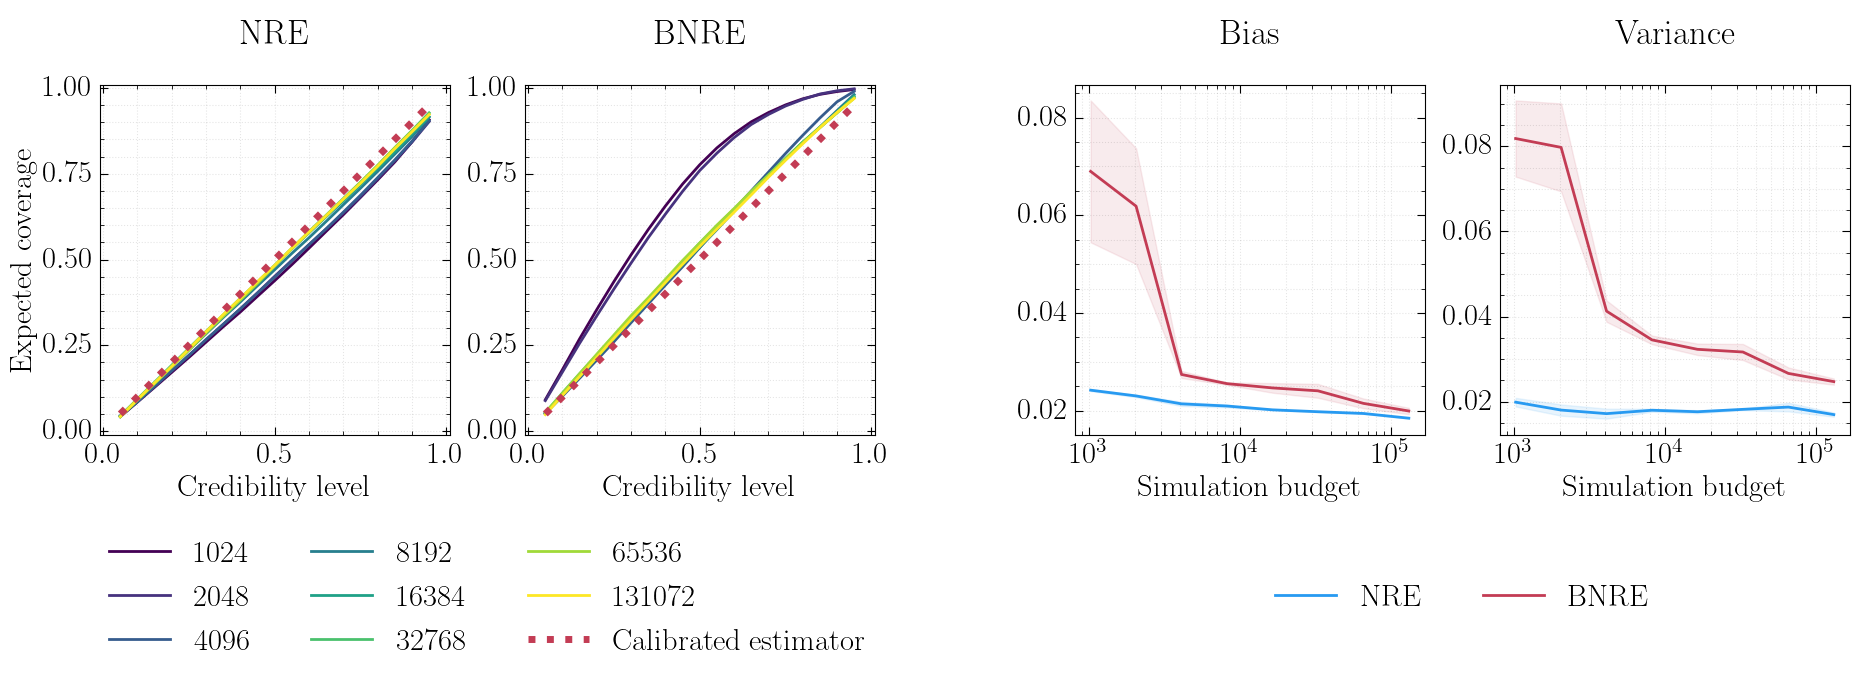

In [90]:
make_illustrative_summary("illustrative_summary.pdf")

## Effect of gamma

In [ ]:
def load_balancing_error(problem, method, budget, gamma=None, schedule=False):
    learning_rate = problem_lrs[problem]
    
    base_query = '../{}/'.format(method) + problem + '/output/estimator/' + str(budget) + '/' + batch_size + '/' + learning_rate
    if gamma is not None:
        base_query += '/' + str(gamma)
    if schedule:
        base_query += '/schedule'
    query = base_query + '/*/balancing.npy'
    
    files = glob.glob(query)
    if len(files) == 0:
        return None
    samples = np.hstack([np.load(f) for f in files])
    
    data = np.mean(np.absolute(1-samples))
            
    return data

In [ ]:
def plot_effect_of_gamma(method, benchmarks, save_name=None, schedule=False):
    # Construct grid
    horiz_sizes = [1.]

    for _ in range(6):
        horiz_sizes += [2.5, 1.]
    horiz_sizes = horiz_sizes[:-1]

    vert_sizes = [0.5]

    for i in range(1):
        if i == 1:
            vert_sizes += [2.5, 1.5]
        else:
            vert_sizes += [2.5, 0.5]

    vert_sizes.append(0.75)

    fig = plt.figure(figsize=[sum(horiz_sizes), sum(vert_sizes)])
    horiz = [Fixed(x) for x in horiz_sizes]
    vert = [Fixed(x) for x in vert_sizes]

    rect = (0.1, 0.1, 0.8, 0.8) # Ignored
    divider = Divider(fig, rect, horiz, vert, aspect=False)
    
    gammas = [float(2**x) for x in range(1, 11)]
    title_size = 25
    
    #auc
    ax = fig.add_axes(rect, label="ax_0")
    ax.set_axes_locator(divider.new_locator(nx=1, ny=1))
    for benchmark in benchmarks:
        data = [area_under_expected_coverage(method, benchmark, 8192, gamma=gamma, schedule=schedule)[0] for gamma in gammas]
        ax.plot(gammas, data, color=problem_colors[benchmark], label=problem_titles[benchmark])
    ax.set_xscale("log")
    
    ax = fig.add_axes(rect, label="text_0")
    ax.set_axes_locator(divider.new_locator(nx=1, ny=3))
    ax.set_axis_off()
    ax.text(0.5, 0.5, "AUC", horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes, fontdict = {'fontsize': title_size})
    
    #biases
    ax = fig.add_axes(rect, label="ax_1")
    ax.set_axes_locator(divider.new_locator(nx=3, ny=1))
    for benchmark in benchmarks:
        data = [load_bias_variance(benchmark, method, "bias", 0, gamma=gamma, schedule=schedule)[0] for gamma in gammas]
        ax.plot(gammas, data, color=problem_colors[benchmark], label=problem_titles[benchmark])
    ax.set_xscale("log")
    
    ax = fig.add_axes(rect, label="text_1")
    ax.set_axes_locator(divider.new_locator(nx=3, ny=3))
    ax.set_axis_off()
    ax.text(0.5, 0.5, "Bias 1", horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes, fontdict = {'fontsize': title_size})
    
    ax = fig.add_axes(rect, label="ax_2")
    ax.set_axes_locator(divider.new_locator(nx=5, ny=1))
    for benchmark in benchmarks:
        data = [load_bias_variance(benchmark, method, "bias", 1, gamma=gamma, schedule=schedule)[0] for gamma in gammas]
        ax.plot(gammas, data, color=problem_colors[benchmark], label=problem_titles[benchmark])
    ax.set_xscale("log")
    
    ax = fig.add_axes(rect, label="text_2")
    ax.set_axes_locator(divider.new_locator(nx=5, ny=3))
    ax.set_axis_off()
    ax.text(0.5, 0.5, "Bias 2", horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes, fontdict = {'fontsize': title_size})
    
    #Variances
    ax = fig.add_axes(rect, label="ax_3")
    ax.set_axes_locator(divider.new_locator(nx=7, ny=1))
    for benchmark in benchmarks:
        data = [load_bias_variance(benchmark, method, "variance", 0, gamma=gamma, schedule=schedule)[0] for gamma in gammas]
        ax.plot(gammas, data, color=problem_colors[benchmark], label=problem_titles[benchmark])
    ax.set_xscale("log")
    
    ax = fig.add_axes(rect, label="text_3")
    ax.set_axes_locator(divider.new_locator(nx=7, ny=3))
    ax.set_axis_off()
    ax.text(0.5, 0.5, "Variance 1", horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes, fontdict = {'fontsize': title_size})
    
    ax = fig.add_axes(rect, label="ax_4_{}".format(benchmark))
    ax.set_axes_locator(divider.new_locator(nx=9, ny=1))
    for benchmark in benchmarks:
        data = [load_bias_variance(benchmark, method, "variance", 1, gamma=gamma, schedule=schedule)[0] for gamma in gammas]
        ax.plot(gammas, data, color=problem_colors[benchmark], label=problem_titles[benchmark])
    ax.set_xscale("log")
    
    ax = fig.add_axes(rect, label="text_4")
    ax.set_axes_locator(divider.new_locator(nx=9, ny=3))
    ax.set_axis_off()
    ax.text(0.5, 0.5, "Variance 2", horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes, fontdict = {'fontsize': title_size})
    
    #Balancing
    ax = fig.add_axes(rect, label="ax_5")
    ax.set_axes_locator(divider.new_locator(nx=11, ny=1))
    for benchmark in benchmarks:

        data = [load_balancing_error(benchmark, method, 8192, gamma=gamma, schedule=schedule) for gamma in gammas]
        ax.plot(gammas, data, color=problem_colors[benchmark], label=problem_titles[benchmark])
    ax.set_xscale("log")
    
    ax = fig.add_axes(rect, label="text_5")
    ax.set_axes_locator(divider.new_locator(nx=11, ny=3))
    ax.set_axis_off()
    ax.text(0.5, 0.5, "Balancing error", horizontalalignment='center', 
                verticalalignment='center', transform=ax.transAxes, fontdict = {'fontsize': title_size})
    
    if save_name is not None:
        plt.savefig(save_name)
    

In [ ]:
plot_effect_of_gamma("kl_cnpe", "lotka_volterra")

In [ ]:
plot_effect_of_gamma("cnre", ["slcp", "spatialsir", "lotka_volterra"])

In [ ]:
plot_effect_of_gamma("cnre", "spatialsir")

In [ ]:
plot_effect_of_gamma("cnre", "spatialsir", schedule=True)

In [ ]:
plot_effect_of_gamma("cnre", "lotka_volterra")

In [ ]:
plot_effect_of_gamma("ratio_cnpe", "lotka_volterra")